In [15]:
!pip install -q medmnist

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
from torchvision import transforms, models
from torch.utils.data import DataLoader, random_split
from medmnist import PathMNIST
import torch.nn.functional as F


In [2]:
#  Device Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Transforms
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor()
])
val_transform = transforms.ToTensor()

Using device: cuda


In [10]:
#  Load official train, validation, and test datasets
train_dataset = PathMNIST(split='train', download=True, transform=train_transform)
val_dataset = PathMNIST(split='val', download=True, transform=val_transform)
test_dataset = PathMNIST(split='test', download=True, transform=val_transform)

#  DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


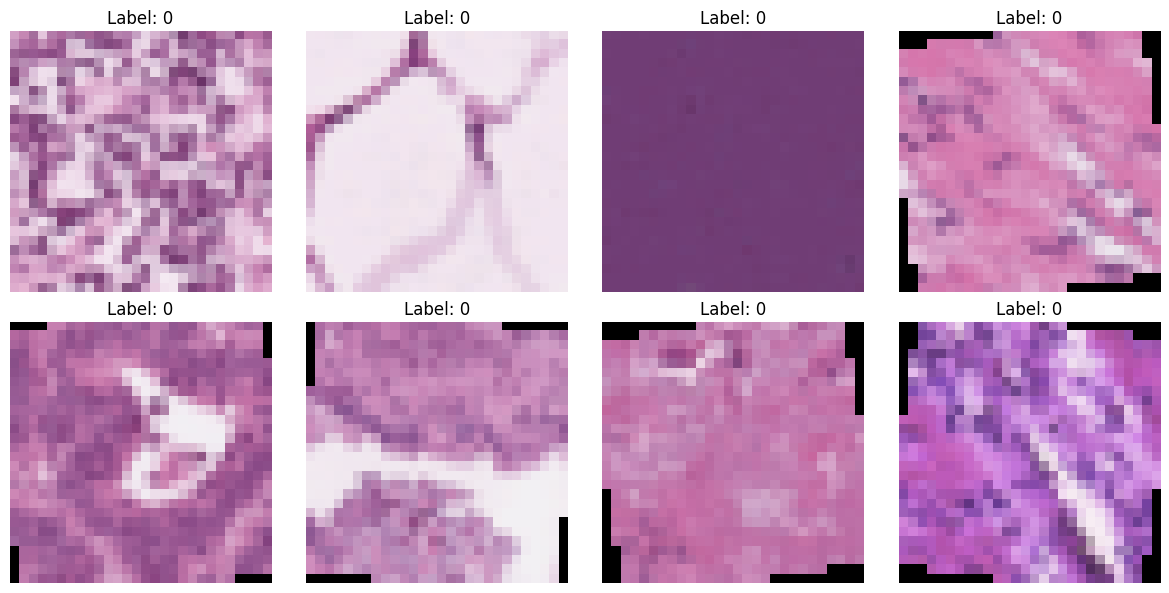

In [11]:
#  Visualize a few samples
images, labels = next(iter(train_loader))
plt.figure(figsize=(12,6))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(images[i].permute(1,2,0))
    lbl = labels[i].argmax().item() if labels[i].ndim > 0 else labels[i].item()
    plt.title(f'Label: {lbl}')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [20]:
#  Load and configure pretrained ResNet10
model = models.resnet18(pretrained=True)
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(model.fc.in_features, 9)
)
model = model.to(device)



In [21]:
#  Training and Validation
num_epochs = 5
noise_rate = 0.05  # 5% noisy labels
train_acc_list = []
val_acc_list = []

for epoch in range(num_epochs):
    model.train()
    correct = 0

    for images, labels in train_loader:
        images = images.to(device)
        if labels.ndim > 1:
            labels = labels.argmax(dim=1)

        # Inject noise: randomly flip some labels
        mask = torch.rand(len(labels)) < noise_rate
        labels[mask] = torch.randint(0, 9, (mask.sum(),))

        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()

    train_acc = correct / len(train_dataset)
    train_acc_list.append(train_acc)

    # Validation
    model.eval()
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images = val_images.to(device)
            if val_labels.ndim > 1:
                val_labels = val_labels.argmax(dim=1)
            val_labels = val_labels.to(device)

            outputs = model(val_images)
            _, val_preds = torch.max(outputs, 1)
            val_correct += (val_preds == val_labels).sum().item()
            val_total += val_labels.size(0)

    val_acc = val_correct / val_total
    val_acc_list.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Acc: {train_acc:.4f} - Val Acc: {val_acc:.4f}")

Epoch 1/5 - Train Acc: 0.0741 - Val Acc: 0.0618
Epoch 2/5 - Train Acc: 0.0715 - Val Acc: 0.0405
Epoch 3/5 - Train Acc: 0.0739 - Val Acc: 0.0778
Epoch 4/5 - Train Acc: 0.0725 - Val Acc: 0.0498
Epoch 5/5 - Train Acc: 0.0727 - Val Acc: 0.0418


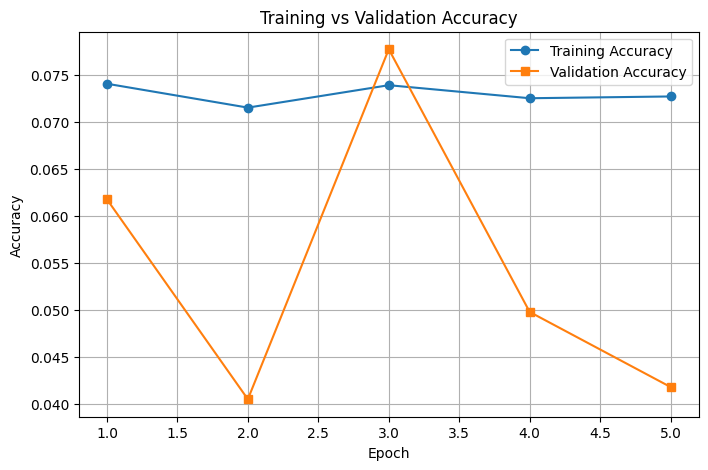

In [22]:
#  Plot Accuracy Curves
plt.figure(figsize=(8,5))
plt.plot(range(1, num_epochs+1), train_acc_list, label='Training Accuracy', marker='o')
plt.plot(range(1, num_epochs+1), val_acc_list, label='Validation Accuracy', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()




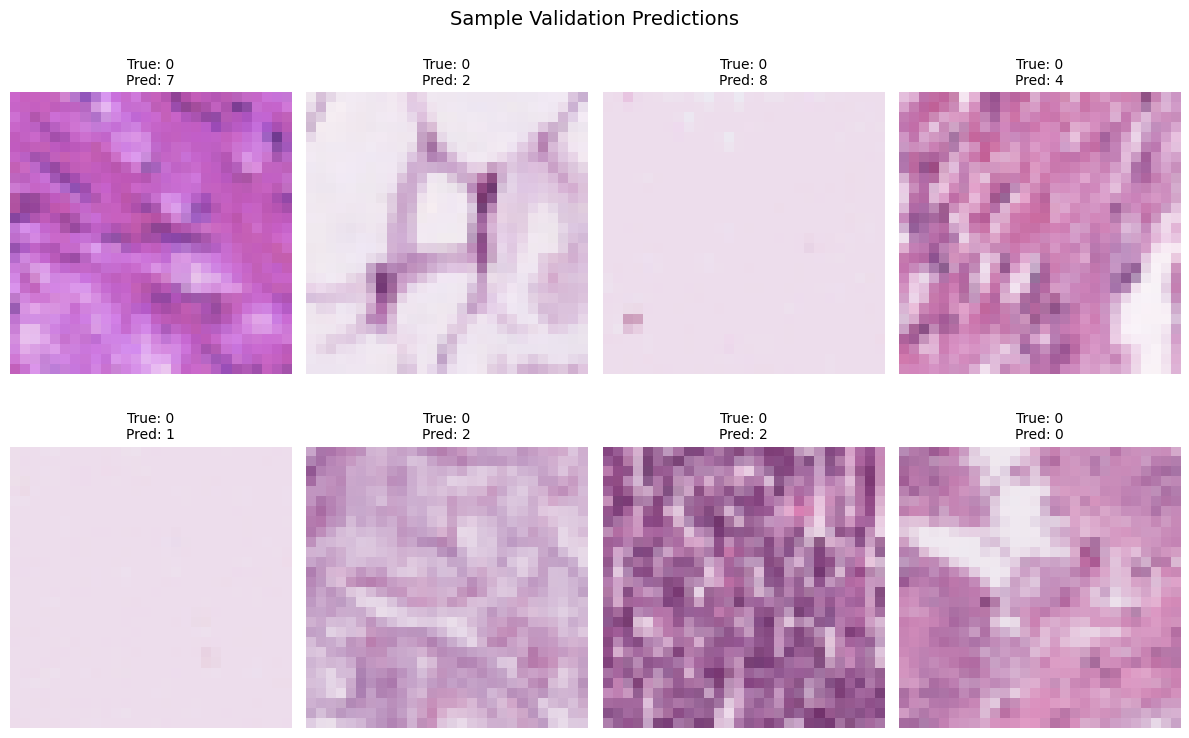

In [23]:
# Visualize Predictions
model.eval()
images, labels = next(iter(val_loader))
images = images.to(device)
if labels.ndim > 1:
    labels = labels.argmax(dim=1)
labels = labels.to(device)

outputs = model(images)
_, preds = torch.max(outputs, 1)

plt.figure(figsize=(12, 8))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(images[i].cpu().permute(1, 2, 0))
    plt.title(f"True: {labels[i].item()}\nPred: {preds[i].item()}", fontsize=10)
    plt.axis('off')
plt.suptitle("Sample Validation Predictions", fontsize=14)
plt.tight_layout()
plt.show()